In [1]:
from functions import *

In [2]:
# Define parameters 
num_monomers = 20 
mean_bond_length = 1
std_bond_length = 20
gaussian_noise_std = 10

num_observation_list = [30, 70]
num_templates = 2

template_chain_list = [generate_gaussian_chain(num_monomers, mean_bond_length, std_bond_length) for i in range(num_templates)]
observation_list = [generate_observations(c, n, gaussian_noise_std) for c, n in zip(template_chain_list, num_observation_list)]

observation_list = np.concatenate([*observation_list])


In [3]:
observation_class_list = np.concatenate([[i for _ in range(j)] for i, j in enumerate(num_observation_list)])

In [4]:
observation_class_list 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [5]:
observations_flatten = jnp.array([generate_flatten_distance_map(o) for o in observation_list])

INFO:jax._src.lib.xla_bridge:Remote TPU is not linked into jax; skipping remote TPU.
INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu_driver': Could not initialize backend 'tpu_driver'


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA
INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


In [6]:
def generate_posterior_parallelize(templates, observations_flatten, template_weights, weight_renormalization=1000):
    """
    """
    templates_flatten = [generate_flatten_distance_map(t) for t in templates]
    
    templates_flatten = jnp.array(templates_flatten)
    observations_flatten = jnp.array(observations_flatten)
    
    template_weights = jnp.array(template_weights)
    
    weight_prior = 1/len(template_weights) 
    
    # Generate grid index combination
    template_info_indices = jnp.arange(len(templates_flatten))
    observation_info_indices = jnp.arange(len(observations_flatten))
    t_ind, o_ind = jnp.meshgrid(template_info_indices, observation_info_indices)
    
    total_posterior = 0
    
    t_ind = t_ind.flatten()
    o_ind = o_ind.flatten()
    
    # jax.debug.print("Weights at current iteration: {y}", y=template_weights)
    def calculate_rhs(t_ind, o_ind):
        val = 0 
        o = observations_flatten[o_ind]
        t = templates_flatten[t_ind]
        alpha = template_weights[t_ind]
        
        val += loglikelihood(o, t, measurement_error, num_probes)

        val += logprior(t, num_probes)

        # This is the correct one 
        # But the scaling between alpha and weight priors and logliokelihood are so different 
        # val += jnp.log(alpha + 1e-32) * weight_renormalization 
        val += jnp.log(jnp.abs(alpha) + 1e-32) * weight_renormalization  # use jnp.abs to make sure that each alpha does not go to 0
        val += jnp.log(weight_prior) * weight_renormalization
           
        return val 
    
    def calculate_posterior(i):
        return jscipy.special.logsumexp(jnp.where(o_ind == i, curr_obs_list, -jnp.inf))
    
    curr_obs_list = jnp.array(jax.vmap(calculate_rhs)(t_ind, o_ind))
    
    total_posterior = jnp.sum(jax.vmap(calculate_posterior)(jnp.arange(len(observations_flatten))))

    return total_posterior

def structure_neg_objective_parallelize(observations_flatten):
    """
    """ 
    jax.debug.print("{x}", x=observations_flatten.shape)
    templates = template_chain_list
    template_weights = num_observation_list
    return -generate_posterior_parallelize(templates, observations_flatten, template_weights)
    

In [7]:
measurement_error = gaussian_noise_std
num_probes = num_monomers

structure_neg_objective_parallelize(observations_flatten)

(100, 400)


Array(-162507.67, dtype=float32)

In [8]:
from jaxopt import ProjectedGradient
from jaxopt.projection import projection_non_negative
pg = ProjectedGradient(fun=structure_neg_objective_parallelize, projection=projection_non_negative, implicit_diff=True, verbose=True)
pg_sol = pg.run(observations_flatten)

(array(100, dtype=int32), array(400, dtype=int32))
(array(100, dtype=int32), array(400, dtype=int32))
INFO: jaxopt.ProximalGradient: Iter: 1 Distance btw Iterates (stop. crit.): 13.613664627075195 Stepsize:2.0 
(array(100, dtype=int32), array(400, dtype=int32))
(array(100, dtype=int32), array(400, dtype=int32))
INFO: jaxopt.ProximalGradient: Iter: 2 Distance btw Iterates (stop. crit.): 13.47752857208252 Stepsize:4.0 
(array(100, dtype=int32), array(400, dtype=int32))
(array(100, dtype=int32), array(400, dtype=int32))
INFO: jaxopt.ProximalGradient: Iter: 3 Distance btw Iterates (stop. crit.): 15.030701637268066 Stepsize:8.0 
(array(100, dtype=int32), array(400, dtype=int32))
(array(100, dtype=int32), array(400, dtype=int32))
INFO: jaxopt.ProximalGradient: Iter: 4 Distance btw Iterates (stop. crit.): 15.60777473449707 Stepsize:16.0 
(array(100, dtype=int32), array(400, dtype=int32))
(array(100, dtype=int32), array(400, dtype=int32))
INFO: jaxopt.ProximalGradient: Iter: 5 Distance btw Ite

In [9]:
sol = pg_sol.params

In [10]:
sol.shape

(100, 400)

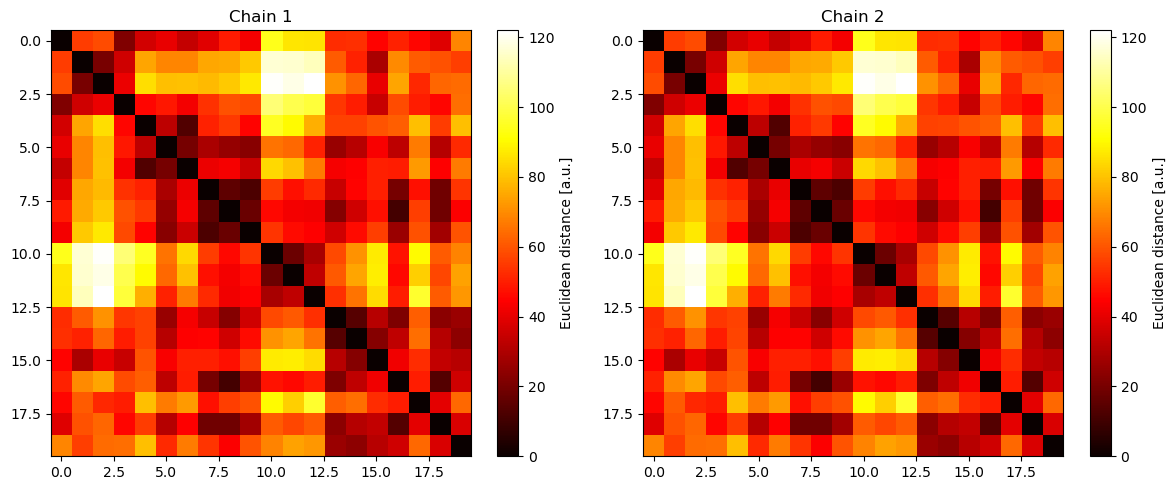

In [11]:
compare_distance_maps(template_chain_list[0], sol[0], type1='polymer', type2='flatten_distance_map')

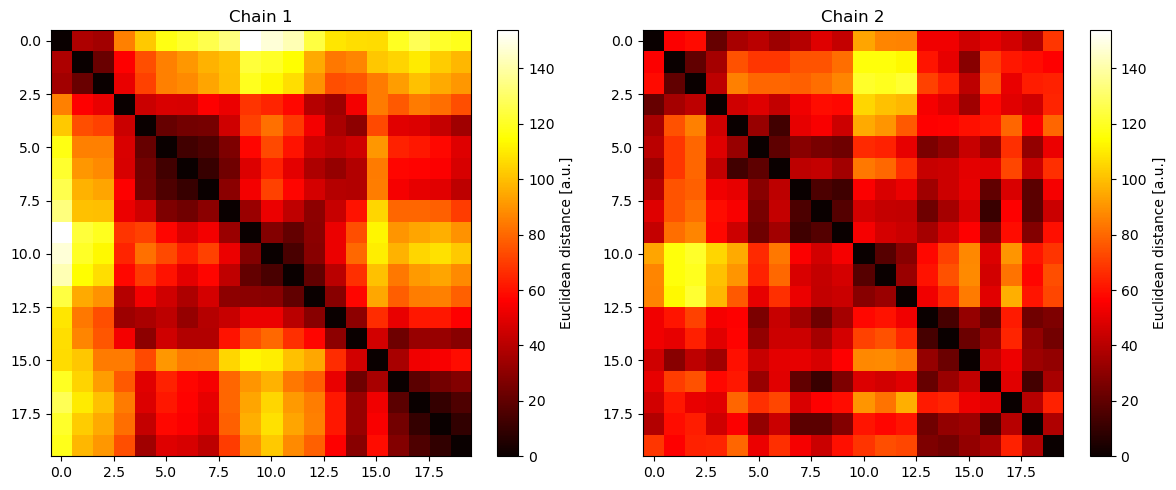

In [12]:
compare_distance_maps(template_chain_list[1], sol[0], type1='polymer', type2='flatten_distance_map')

In [13]:
reducer = umap.UMAP()

In [14]:
reducer.fit(sol);

Text(0.5, 1.0, 'UMAP projection of distance maps')

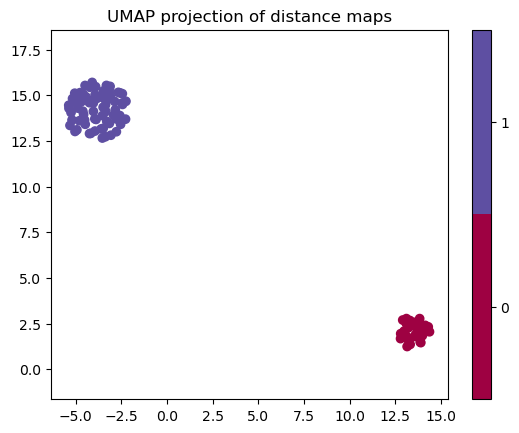

In [15]:
embedding = reducer.transform(sol)
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=observation_class_list, 
    cmap='Spectral')
plt.colorbar(boundaries=np.arange(3)-0.5).set_ticks(np.arange(2))
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of distance maps')

In [16]:
template_flatten_list = [generate_flatten_distance_map(t) for t in template_chain_list]

In [17]:
len(template_flatten_list)

2

In [18]:
template_fit = reducer.transform(jnp.array(template_flatten_list))

Text(0.5, 1.0, 'UMAP projection of distance maps')

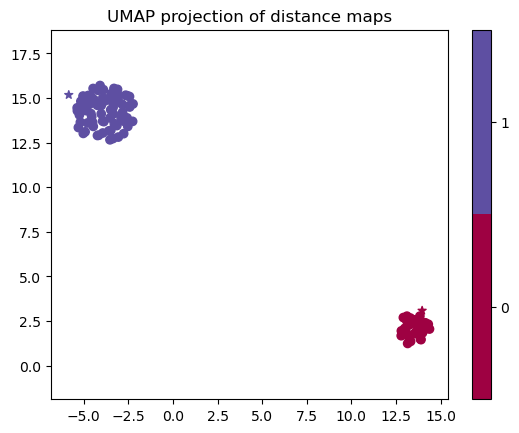

In [19]:
embedding = reducer.transform(sol)
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=observation_class_list, 
    cmap='Spectral')
plt.scatter(
    template_fit[:, 0],
    template_fit[:, 1],
    c=[x for x in range(len(template_fit))],
    marker='*',
    cmap='Spectral'
    )
plt.colorbar(boundaries=np.arange(3)-0.5).set_ticks(np.arange(2))
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of distance maps')

In [20]:
# Now lets add more models to see if it helps? 

templates_with_observations = jnp.array(np.concatenate([template_chain_list, observation_list]))
templates_with_observations_flatten = jnp.array([generate_flatten_distance_map(x) for x in templates_with_observations])

In [21]:
def generate_posterior_parallelize(templates, observations_flatten, template_weights, weight_renormalization=1000):
    """
    """
    templates_flatten = [generate_flatten_distance_map(t) for t in templates]
    
    templates_flatten = jnp.array(templates_flatten)
    observations_flatten = jnp.array(observations_flatten)
    
    template_weights = jnp.array(template_weights)
    
    weight_prior = 1/len(template_weights) 
    
    # Generate grid index combination
    template_info_indices = jnp.arange(len(templates_flatten))
    observation_info_indices = jnp.arange(len(observations_flatten))
    t_ind, o_ind = jnp.meshgrid(template_info_indices, observation_info_indices)
    
    total_posterior = 0
    
    t_ind = t_ind.flatten()
    o_ind = o_ind.flatten()
    
    # jax.debug.print("Weights at current iteration: {y}", y=template_weights)
    def calculate_rhs(t_ind, o_ind):
        val = 0 
        o = observations_flatten[o_ind]
        t = templates_flatten[t_ind]
        alpha = template_weights[t_ind]
        
        val += loglikelihood(o, t, measurement_error, num_probes)

        val += logprior(t, num_probes)

        # This is the correct one 
        # But the scaling between alpha and weight priors and logliokelihood are so different 
        # val += jnp.log(alpha + 1e-32) * weight_renormalization 
        val += jnp.log(jnp.abs(alpha) + 1e-32) * weight_renormalization  # use jnp.abs to make sure that each alpha does not go to 0
        val += jnp.log(weight_prior) * weight_renormalization
           
        return val 
    
    def calculate_posterior(i):
        return jscipy.special.logsumexp(jnp.where(o_ind == i, curr_obs_list, -jnp.inf))
    
    curr_obs_list = jnp.array(jax.vmap(calculate_rhs)(t_ind, o_ind))
    
    total_posterior = jnp.sum(jax.vmap(calculate_posterior)(jnp.arange(len(observations_flatten))))

    return total_posterior

def structure_neg_objective_parallelize(templates):
    """
    """ 
    template_weights = num_observation_list
    return -generate_posterior_parallelize(templates, observations_flatten, template_weights)

In [22]:
posterior_list = []
for i in tqdm(range(1, len(templates_with_observations)+1)):
    posterior_list.append(structure_neg_objective_parallelize(templates_with_observations[:i]))

  0%|          | 0/102 [00:00<?, ?it/s]

In [23]:
posterior_list = -np.array(posterior_list)
posterior_list_norm = posterior_list / np.arange(1, len(posterior_list)+1)

Text(0.5, 0, 'Number of models')

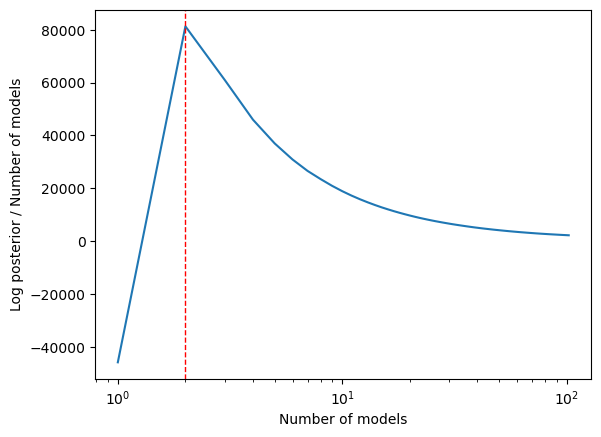

In [25]:
plt.semilogx(np.arange(1, len(posterior_list)+1), posterior_list_norm)
plt.axvline(x=2, color='r', linestyle='--', linewidth=1)
plt.ylabel('Log posterior / Number of models')
plt.xlabel('Number of models')